# Structured Artificial Intelligence Final Report

- t-SNE comparison between CLIP(Using Cntrastive Learning) and MAE(Using Masked Image Modeling)

## t-SNE visualization of CLIP and MAE embeddings

### prepare dataset (CIFAR10)

In [1]:
import torch
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np

# データ準備
transform = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

dataset = CIFAR10(root='/DeepLearning/Dataset/torchvision/CIFAR10', train=False, download=False, transform=transform)
loader = DataLoader(dataset, batch_size=64, shuffle=False)

# ラベル取得
labels_map = dataset.classes
all_labels = []


### download clip and extracting feature

In [2]:
import clip

def extract_clip_features(model, preprocess, loader, device):
    features = []
    all_labels = []
    with torch.no_grad():
        for images, labels in tqdm(loader):
            images = images.to(device)
            feats = model.encode_image(images).float()
            feats = feats / feats.norm(dim=1, keepdim=True)
            features.append(feats.cpu())
            all_labels.extend(labels)
    return torch.cat(features).numpy(), all_labels

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
clip_features, clip_labels = extract_clip_features(clip_model, clip_preprocess, loader, device)


100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 45.2MiB/s]
100%|██████████| 157/157 [15:38<00:00,  5.98s/it]


### download mae and extracting feature

In [6]:
from torchvision.datasets import CIFAR10
from PIL import Image
from torch.utils.data import DataLoader

# PIL画像を保持したまま渡す
dataset_raw = CIFAR10(root='/DeepLearning/Dataset/torchvision/CIFAR10', train=False, download=False)


# PIL画像を含むバッチをそのまま返す関数
def pil_collate_fn(batch):
    images, labels = zip(*batch)  # list of PIL.Image, list of int
    return list(images), list(labels)

# MAE用の DataLoader を定義（collate_fnを上書き）
loader_raw = DataLoader(dataset_raw, batch_size=64, shuffle=False, collate_fn=pil_collate_fn)


# MAE用抽出関数を修正
def extract_mae_features(model, processor, loader, device):
    features = []
    all_labels = []
    with torch.no_grad():
        for images, labels in tqdm(loader):
            inputs = processor(images=list(images), return_tensors="pt").to(device)
            outputs = model(**inputs)
            feats = outputs.last_hidden_state[:, 0, :]  # CLS token
            feats = feats / feats.norm(dim=1, keepdim=True)
            features.append(feats.cpu())
            all_labels.extend(labels)
    return torch.cat(features).numpy(), all_labels

# 実行
from transformers import AutoImageProcessor, AutoModel
mae_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base")
mae_model = AutoModel.from_pretrained("facebook/vit-mae-base").to(device).eval()
mae_features, mae_labels = extract_mae_features(mae_model, mae_processor, loader_raw, device)


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
100%|██████████| 157/157 [00:33<00:00,  4.69it/s]


### Visualise feature distribution map using t-SNE

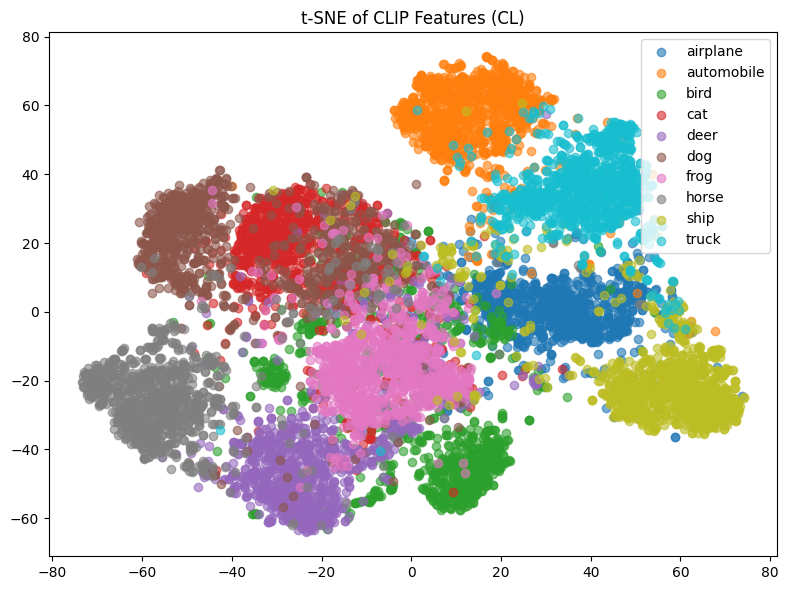

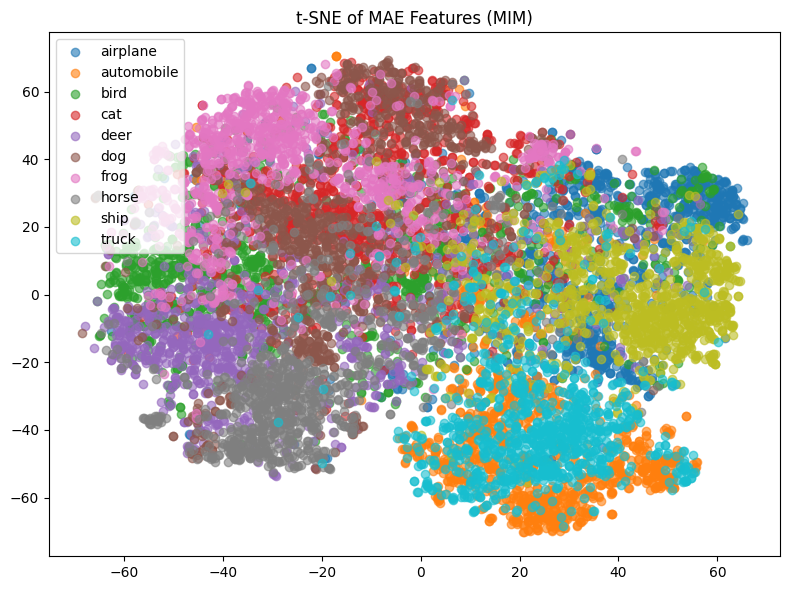

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(features, labels, title):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced = tsne.fit_transform(features)
    labels = np.array(labels)
    plt.figure(figsize=(8, 6))
    for i in range(10):
        idx = labels == i
        plt.scatter(reduced[idx, 0], reduced[idx, 1], label=labels_map[i], alpha=0.6)
    plt.legend()
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_tsne(clip_features, clip_labels, "t-SNE of CLIP Features (CL)")
plot_tsne(mae_features, mae_labels, "t-SNE of MAE Features (MIM)")


## Retrival image comparison

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from skimage.metrics import structural_similarity as ssim
from skimage.color import rgb2gray
from skimage.filters import sobel
from PIL import Image
from tqdm import tqdm
import matplotlib.gridspec as gridspec

### setup dataset (CIFAR10)

In [ ]:
# データ読み込み
cifar_dataset = CIFAR10(root="/DeepLearning/Dataset/torchvision/CIFAR10", train=False, download=False)
raw_images = [img for img, _ in cifar_dataset]
labels = [label for _, label in cifar_dataset]
class_names = cifar_dataset.classes

### extract features using CLIP and MAE

In [14]:
# ---- 特徴ベクトル（実際はCLIPとMAEから抽出してください） ----
# 今は仮でランダム生成
np.random.seed(0)
# clip_features = np.random.rand(len(raw_images), 512)
clip_features, clip_labels = extract_clip_features(clip_model, clip_preprocess, loader, device)
# mae_features = np.random.rand(len(raw_images), 768)
mae_features, mae_labels = extract_mae_features(mae_model, mae_processor, loader_raw, device)
clip_features /= np.linalg.norm(clip_features, axis=1, keepdims=True)
mae_features /= np.linalg.norm(mae_features, axis=1, keepdims=True)

100%|██████████| 157/157 [00:33<00:00,  4.64it/s]


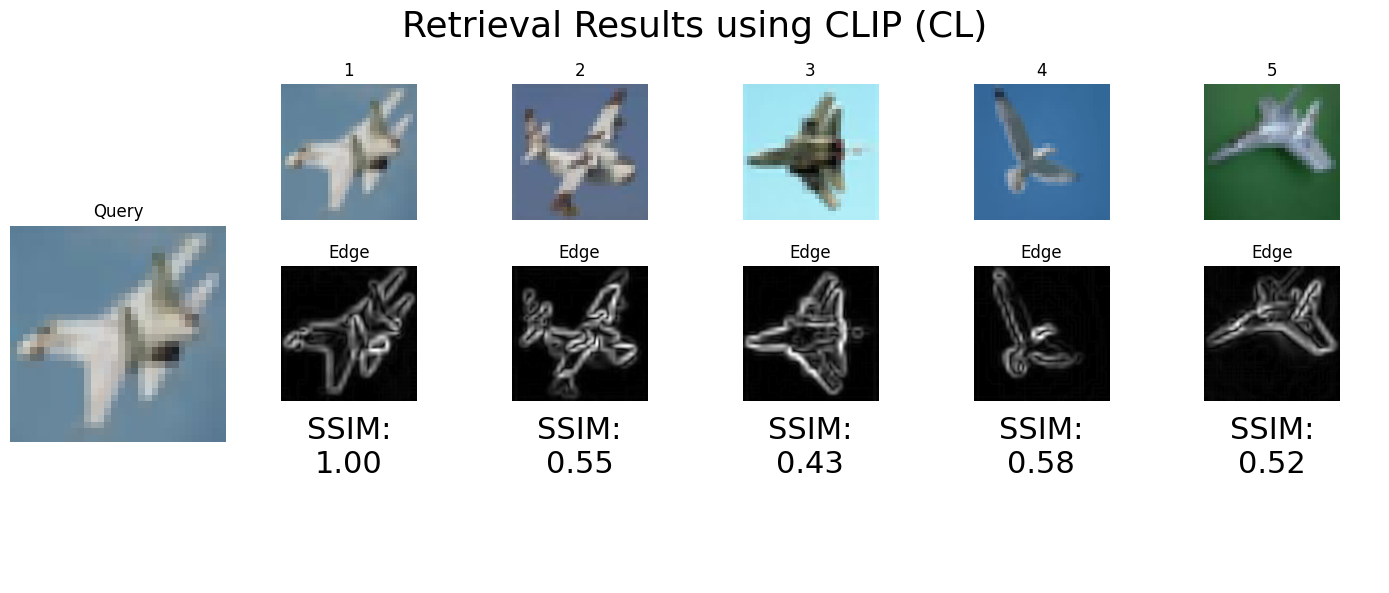

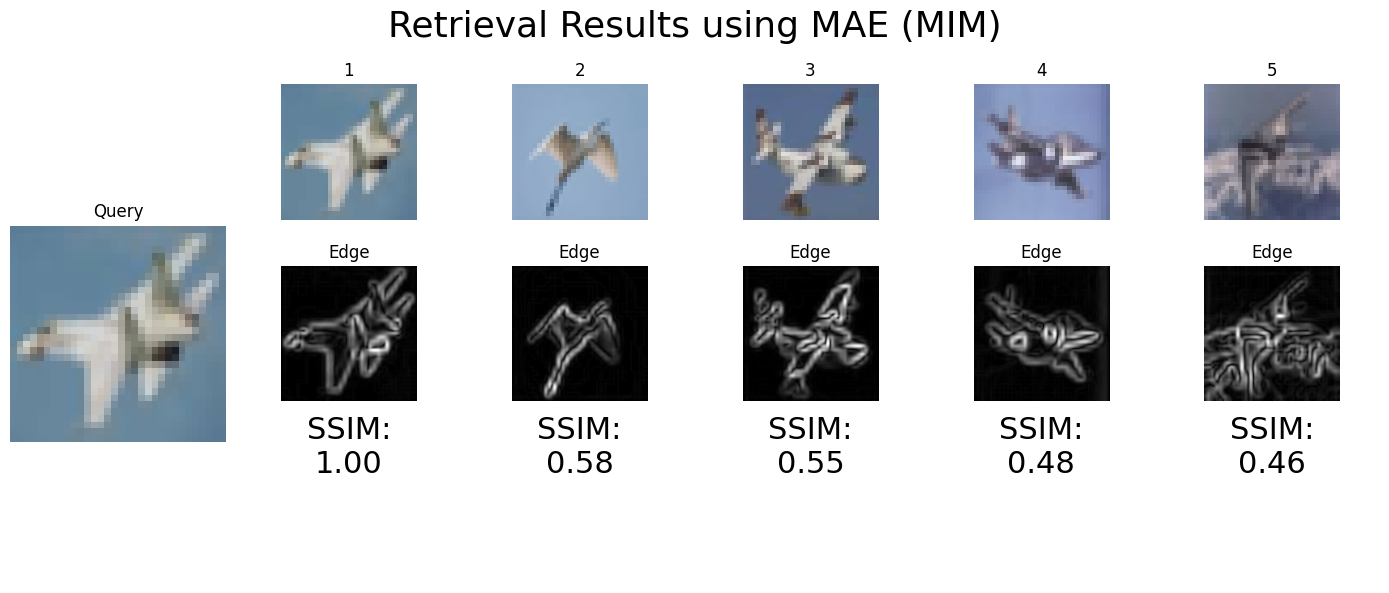

In [19]:
# クエリ画像を選ぶ
query_index = 10
query_image = raw_images[query_index]

# 類似画像検索（コサイン類似度）
def get_top_k_similar(query_feat, all_feats, k=5):
    sim = np.dot(all_feats, query_feat)
    topk_idx = np.argsort(sim)[-k:][::-1]
    return topk_idx, sim[topk_idx]

clip_topk_idx, _ = get_top_k_similar(clip_features[query_index], clip_features)
mae_topk_idx, _ = get_top_k_similar(mae_features[query_index], mae_features)

# エッジマップ生成
def edge_map(img_pil):
    img_gray = rgb2gray(np.array(img_pil.resize((128, 128))))
    return sobel(img_gray)

# SSIM計算
def compute_ssim(img1, img2):
    img1 = rgb2gray(np.array(img1.resize((128, 128))))
    img2 = rgb2gray(np.array(img2.resize((128, 128))))
    return ssim(img1, img2, data_range=1.0)

# 可視化関数
def visualize_retrieval(query_img, topk_idx, method_name):
    fig = plt.figure(figsize=(14, 6))
    gs = gridspec.GridSpec(3, 6)

    # クエリ画像
    ax0 = plt.subplot(gs[:, 0])
    ax0.imshow(query_img)
    ax0.set_title("Query")
    ax0.axis('off')

    # 検索結果
    for i, idx in enumerate(topk_idx):
        retrieved_img = raw_images[idx]

        ax_img = plt.subplot(gs[0, i+1])
        ax_img.imshow(retrieved_img)
        ax_img.set_title(f"{i+1}")
        ax_img.axis('off')

        # エッジマップ
        ax_edge = plt.subplot(gs[1, i+1])
        ax_edge.imshow(edge_map(retrieved_img), cmap='gray')
        ax_edge.set_title("Edge")
        ax_edge.axis('off')

        # SSIM表示
        ssim_val = compute_ssim(query_img, retrieved_img)
        ax_ssim = plt.subplot(gs[2, i+1])
        ax_ssim.text(0.5, 1.0, f"SSIM:\n{ssim_val:.2f}", ha='center', va='center', fontsize=22)
        ax_ssim.axis('off')

    plt.suptitle(f"Retrieval Results using {method_name}", fontsize=26)
    plt.tight_layout()
    plt.show()

# CLIPとMAEの比較
visualize_retrieval(query_image, clip_topk_idx, "CLIP (CL)")
visualize_retrieval(query_image, mae_topk_idx, "MAE (MIM)")
